# Network Analysis Using OSM Road Networks

In [1]:
import swat
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),r"../../common/python"))
import cas_connection as cas
import warnings
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# Road Network Data

OpenStreetMap (OSM)[<sup>[1]</sup>]() is a free, community-maintained database of geographic features worldwide including landmarks and transportation networks. OSM combines official datasets from the public domain with additional data collected from satellite imagery, GPS tracking, and ground survey.  As one of the most comprehensive open geodata sources publicly available, it is commonly used for mapping and navigation projects.

The Python package OSMnx is an open source toolkit for conveniently retrieving, converting, and analyzing OSM data as graphs.  We use OSMnx to help generate a road network from the OSM data of the major roads and highways in the contiguous United States. Then, using SAS Viya through the SWAT package, we can perform various analyses on the resulting network.

The entire OSM database contains significantly more data than we will use in this demonstration-- all we need are the major roads in the contiguous United States.  We must specify the geographic extent of the data we want to retrieve from OSM.  The OSMnx function geocode_to_gdf() takes a text-based query of the location(s) of interest and returns a geodataframe.

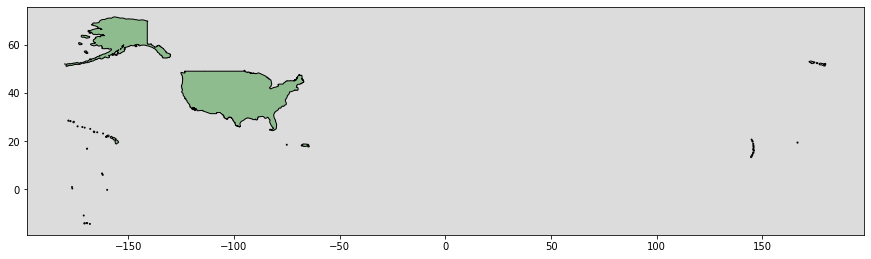

In [2]:
us_gdf = ox.geocode_to_gdf('USA')
fig, ax = plt.subplots(figsize = (15, 10), frameon = False)
ax.set_facecolor('gainsboro')
us_gdf.plot(ax = ax, color = 'darkseagreen')
us_gdf.boundary.plot(ax = ax, color = 'black', lw = 1);

The query 'USA' returned all of the United States territories.  For our examples here, we focus on the contiguous United States, so we must isolate the single polygon of interest.

In [3]:
us_polys = us_gdf.explode().reset_index()
us_poly_gdf = us_polys[us_polys.area == us_polys.area.max()]
contiguous_us_poly = list(us_poly_gdf['geometry'])[0]

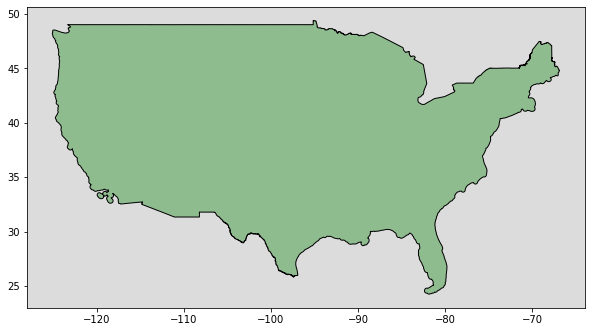

In [4]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.set_facecolor('gainsboro')
us_poly_gdf.plot(ax = ax, color = 'darkseagreen')
us_poly_gdf.boundary.plot(ax = ax, color = 'black', lw = 1);

With this polygon we can use the OSMnx function graph_from_polygon() to retrieve OSM data within the geographic region and convert it into a graph.  We further specify that we are interested only in data from the (driving) road network and use a custom filter to limit the request to only the major roads ('motorway', 'trunk', and 'primary' highways are the OSM classifications for the three most significant road types).

Because the region is so large, downloading all of the road data and constructing the corresponding network graph can take a considerable amount of time (about an hour). We've saved the resulting graph to a graphml file to more efficiently load in future analyses.

In [5]:
graph_file_name = 'graph_US_poly.graphml'
if os.path.exists(graph_file_name):
    G_US_roads = ox.load_graphml(graph_file_name)
else:
    # Takes a long time to run:
    ox.settings.log_console = True
    ox.settings.max_query_area_size = 25e10
    G_us_poly = ox.graph_from_polygon(contiguous_us_poly, network_type = 'drive',
                                    custom_filter = '["highway"~"motorway|trunk|primary|motorway_link|trunk_link|primary_link"]', truncate_by_edge = True, retain_all = True)
    ox.save_graphml(G_us_poly, filepath = graph_file_name)


The resulting road network is represented as a directed graph in which each node corresponds to either an intersection of three or more road segments (e.g. two major roads intersecting) or an endpoint of a road segment (e.g. where a major road transitions to a lower category road).   Intersections of exactly two road segments have been removed from the graph by default in OSMnx's network simplification step.  However the geographic extent (including curves and bends) of each road segment is retained for visualization and analysis.

For our examples here, we focus on the largest strongly connected component of the resulting road network, as we do not want drivers to get 'stuck' in a region of the graph.

In [6]:
G_US_roads_scc = nx.subgraph(G_US_roads, max(nx.strongly_connected_components(G_US_roads), key = len))

The resulting strongly connected network has 476,137 nodes and 799,057 edges.

In [7]:
G_US_roads_scc.number_of_nodes(), G_US_roads_scc.number_of_edges()

(476137, 799057)

Finally, because OSM includes data on speed limits, we can use a combination of estimated road speed and distance to form a better approximation of travel time than road distance alone provides.  OSMnx includes convenient tools to impute missing road speeds and then add a travel time attribute to each edge.

In [8]:
G_US_roads_scc = ox.speed.add_edge_speeds(G_US_roads_scc)
G_US_roads_scc = ox.speed.add_edge_travel_times(G_US_roads_scc)

Converting the graph's nodes and edges into geodataframes is convenient for visualization and analyses.

In [9]:
G_nodes_gdf, G_edges_gdf = ox.graph_to_gdfs(G_US_roads_scc)
G_edges_gdf = G_edges_gdf.reset_index()
G_nodes_gdf = G_nodes_gdf.reset_index()
G_edges_gdf_dedup = G_edges_gdf.sort_values(by = 'travel_time').drop_duplicates(subset = ['u','v'], keep = 'first')


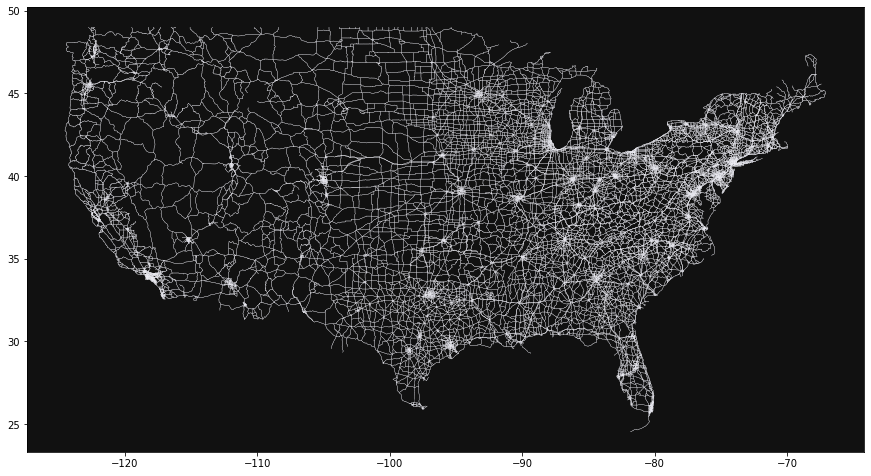

In [10]:
bgcolor = "#111111"
fig_roads, ax_roads = plt.subplots(figsize = (15,15), facecolor = bgcolor, frameon = False)
ax_roads.set_facecolor(bgcolor)
ax_roads = G_edges_gdf.plot(ax = ax_roads, color = "ghostwhite", lw = 0.25, zorder = 0)

# State Capital Tour

Now that we have retrieved and converted the US road network into a graph, we can perform various analyses using the driving travel time metric.  

As an illustration, we'll analyze the Traveling Salesman Problem (TSP) to find the shortest tour for visiting all of the US capital cities (capitals of the 48 contiguous states plus Washington, D.C.).  This is the same problem shown in a SAS documentation example (https://go.documentation.sas.com/doc/en/pgmsascdc/v_046/casnopt/casnopt_optnet_examples06.htm), however here we use driving travel times as our distance metric instead of geodetic distances used in the documentation example.  We can then compare the two resulting tours.

For each of the (contiguous) US capital cities, we use the OSMnx geocode() function to identify a latitude-longitude coordinate pair.  We then compile all city coordinates into a geodataframe.

In [11]:
state_cap_dict = {"Alabama": "Montgomery", "Arizona": "Phoenix", "Arkansas": "Little Rock", "California": "Sacramento", "Colorado": "Denver", "Connecticut": "Hartford", "Delaware": "Dover", "Florida": "Tallahassee", "Georgia": "Atlanta", "Idaho": "Boise", "Illinois": "Springfield", "Indiana": "Indianapolis", "Iowa": "Des Moines", "Kansas": "Topeka", "Kentucky": "Frankfort", "Louisiana": "Baton Rouge", "Maine": "Augusta", "Maryland": "Annapolis", "Massachusetts": "Boston", "Michigan": "Lansing", "Minnesota": "Saint Paul", "Mississippi": "Jackson", "Missouri": "Jefferson City", "Montana": "Helena", "Nebraska": "Lincoln", "Nevada": "Carson City", "New Hampshire": "Concord", "New Jersey": "Trenton", "New Mexico": "Santa Fe", "New York": "Albany", "North Carolina": "Raleigh", "North Dakota": "Bismarck", "Ohio": "Columbus", "Oklahoma": "Oklahoma City", "Oregon": "Salem", "Pennsylvania": "Harrisburg", "Rhode Island": "Providence", "South Carolina": "Columbia", "South Dakota": "Pierre", "Tennessee": "Nashville", "Texas": "Austin", "Utah": "Salt Lake City", "Vermont": "Montpelier", "Virginia": "Richmond", "Washington": "Olympia", "West Virginia": "Charleston", "Wisconsin": "Madison", "Wyoming": "Cheyenne", "DC":"Washington"}
states = state_cap_dict.keys()
cap_coords = {}
for state in states:
    cap_coords[state] = ox.geocode(f"{state_cap_dict[state]}, {state}, USA")
cap_coords_df = pd.DataFrame({"state": states, "capital": [state_cap_dict[state] for state in states], "lat": [cap_coords[state][0] for state in states], "lon": [cap_coords[state][1] for state in states]})
cap_coords_gdf = gpd.GeoDataFrame(cap_coords_df, geometry = gpd.points_from_xy(cap_coords_df.lon, cap_coords_df.lat), crs = G_nodes_gdf.crs)

Recall the nodes in our network correspond to intersections and endpoints of major roads.  There is unlikely to be a node at the exact coordinates for the city, so we instead identify the node in the network closest to each city point.  These nodes will be the terminals for our TSP tour.

In [12]:
cap_closest_nodes = ox.distance.nearest_nodes(G_US_roads_scc, cap_coords_gdf['lon'], cap_coords_gdf['lat'])
nodes_cap_df = G_nodes_gdf[G_nodes_gdf['osmid'].isin(cap_closest_nodes)]

We can visualize the US capital city coordinates (green squares) compared to the nearest major road network nodes (red circles) to confirm that the two sets align well.  Although there are a few places where the circles are off center from the squares (e.g. Lansing, Michigan and Santa Fe, New Mexico), most fall very near to the centers.  Of course these city coordinates are only representative points for the capitals--the actual city boundaries are likely to contain these nodes.

A downloaded shapefile of the US state borders from the US Census[<sup>[2]</sup>]() helps contextualize the visualization.

In [13]:
us_shp_url = f'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip'
us_state_borders = gpd.read_file(us_shp_url)
us_state_borders = us_state_borders[~us_state_borders['STUSPS'].isin(['GU','VI','AS','AK','HI','MP','PR'])] #remove territory outside of contiguous US

<Axes: >

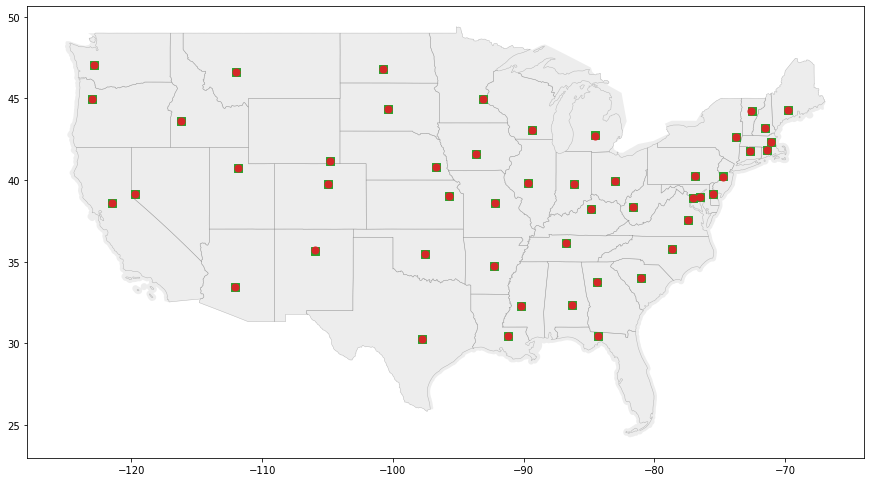

In [14]:
markersize = 50
fig,ax = plt.subplots(figsize = (15,15))
cap_coords_gdf.plot(ax = ax, zorder = 5, color = 'tab:green', markersize = markersize, marker = 's')
nodes_cap_df.plot(ax = ax, zorder = 5, color = 'tab:red', markersize = markersize)
us_state_borders.boundary.plot(ax = ax, color = 'gray', lw = 0.5, alpha = 0.5, zorder = 0)
us_poly_gdf.plot(ax = ax, zorder = -1, color = 'lightgray', alpha = 0.4)

Now we can use SWAT to set up the CAS connection, load the action sets, and upload the road network tables.

In [15]:
s = cas.reconnect()
swat.options.cas.print_messages = False
s.loadactionset("network")
s.loadActionSet('optNetwork');

In [16]:
s.upload(G_edges_gdf_dedup[['u','v','osmid','travel_time']], casout = {'name': 'cas_links', 'replace': True})
s.upload(G_nodes_gdf[['osmid','x','y']], casout = {'name': 'cas_nodes', 'replace': True});

## Shortest Paths

In a typical TSP instance, the tour must visit every node in the network.  Here we are only requiring that the tour visit a small subset of the network's nodes (49 out of over 400,000).  We address this by first performing an all-pairs shortest path calculation to get shortest path distances (as well as the paths themselves) among all of the capital cities.

In [17]:
cap_source_sink_df = pd.DataFrame.from_dict({'node': cap_closest_nodes, 'source': 1, 'sink': 1})
s.upload(cap_source_sink_df, casout = {'name': 'cas_nodes_subset_cap', 'replace': True});

In [18]:
s.optNetwork.shortestPath(
            links     = {'name': 'cas_links'},
            direction = 'directed',
            nodessubset = {'name': 'cas_nodes_subset_cap'},
            linksvar  = {'weight': 'travel_time','from_': 'u', 'to': 'v'},
            outPaths  = {'name': 'ShortPathP_cap', 'replace': True},
            outWeights  = {'name': 'OutWeightP_cap', 'replace': True});

In [19]:
cap_shortest_paths = s.CASTable('ShortPathP_cap').to_frame().astype({'source': 'int','sink': 'int'})

## TSP

We then use the resulting shortest path distances among the cities as input to the TSP instance.  That is, the input for the final TSP instance is a complete directed graph whose vertices are the US capital city nodes and whose edge lengths are the shortest path distances in the original road network.

In [20]:
s.optNetwork.tsp(
            links     = {'name': 'OutWeightP_cap'},
            direction = 'directed',
            linksvar  = {'weight': 'path_weight','from_': 'source', 'to': 'sink'},
            outNodes  = {'name': 'tspOutNodes_cap', 'replace': True});

From the TSP output, we get the order in which the cities are visited in the tour. But in order to get the actual tour through the road network, we use the previously-calculated shortest paths between the cities.  Specifically we concatenate the shortest paths in TSP order.

In [21]:
tsp_node_prder_df = s.CASTable('tspOutNodes_cap').to_frame().sort_values(by = 'tsp_order').astype('int')
ordered_TSP_nodes = list(tsp_node_prder_df['node'])

In [22]:
tsp_paths_st_pairs = [(ordered_TSP_nodes[i],ordered_TSP_nodes[(i+1)%len(ordered_TSP_nodes)]) for i in range(len(ordered_TSP_nodes))]
tsp_shortest_paths = cap_shortest_paths[pd.Series(list(zip(cap_shortest_paths.source, cap_shortest_paths.sink)), index = cap_shortest_paths.index).isin(tsp_paths_st_pairs)]
tsp_shortest_paths = G_edges_gdf_dedup[['u','v','geometry','length']].merge(tsp_shortest_paths, how = 'right')

The resulting tour has a total travel time of about 200 hours and covers a total of about 21,000 km (13,000 miles).

In [23]:
print(round(tsp_shortest_paths['travel_time'].sum()/3600),round(tsp_shortest_paths['length'].sum()/1000),round(tsp_shortest_paths['length'].sum()/1609))

200 21149 13144


### Visualizing the Tour

Finally, we can visualize the TSP tour, both as a cycle in the road network and overlaid on the US map.

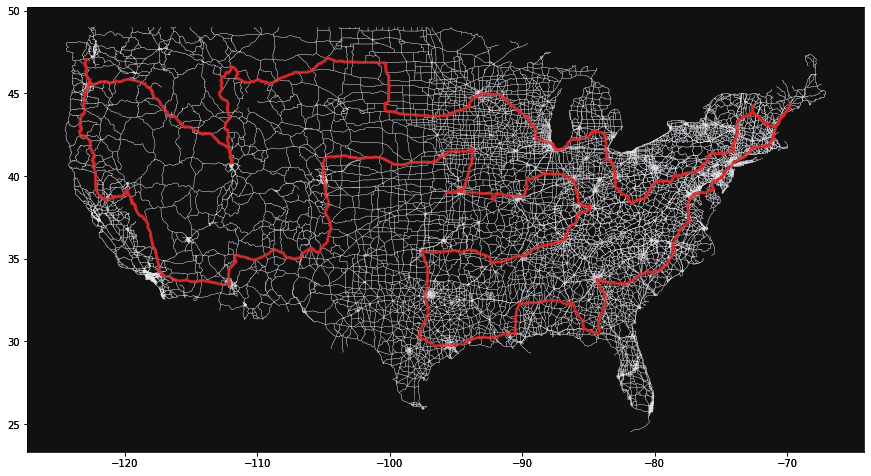

<Figure size 432x288 with 0 Axes>

In [24]:
ax2 = fig_roads.add_axes(ax_roads.get_position(), frameon = False, sharex = ax_roads, sharey = ax_roads)
tsp_shortest_paths.plot(ax = ax2, color = "tab:red", lw = 3, alpha = 1, zorder = 1)
ax2.set_aspect(ax_roads.get_aspect())
fig_roads

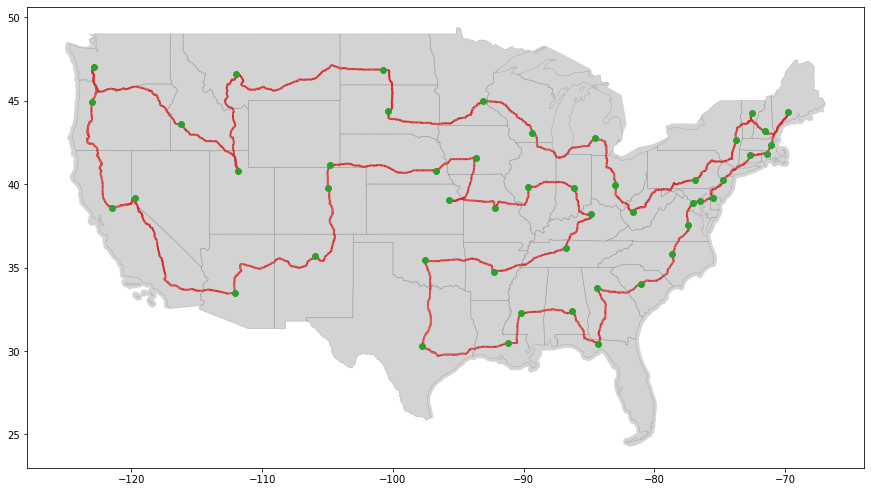

In [25]:
fig,ax = plt.subplots(figsize = (15,15))
cap_coords_gdf.plot(ax = ax, zorder = 5, color = 'tab:green')
us_state_borders.boundary.plot(ax = ax, color = 'gray', lw = 0.5, alpha = 0.5, zorder = 0)
us_poly_gdf.plot(ax = ax, zorder = -1, color = 'lightgray')
ax = tsp_shortest_paths.plot(ax = ax, color = "tab:red", lw = 2, alpha = 1, zorder = 1)

## Comparing Tours

We now turn back to the question of whether the choice of distance metric affects the TSP tour of the capital cities.  We compare our road network tour above with an alternative approach that does not use the road network at all.  Instead distances between capital cities are determined entirely by the geometric distances between their (projected) geographic coordinates.  TSP is then calculated using these alternative distances.

In [26]:
cap1 = cap_coords_gdf.rename(columns = {c: c+'_1' for c in cap_coords_gdf.columns})
cap2 = cap_coords_gdf.rename(columns = {c: c+'_2' for c in cap_coords_gdf.columns})
cap1['key'] = 0
cap2['key'] = 0
cap_to_cap_df = cap1.merge(cap2, how = 'outer')
cap_to_cap_df = cap_to_cap_df[cap_to_cap_df['state_1'] != cap_to_cap_df['state_2']]

cap_to_cap_df['distance'] = gpd.GeoSeries(cap_to_cap_df['geometry_1']).to_crs("ESRI:102003").distance(gpd.GeoSeries(cap_to_cap_df['geometry_2']).to_crs("ESRI:102003"), align = False)
cap_to_cap_df

,state_1,capital_1,lat_1,lon_1,geometry_1,key,state_2,capital_2,lat_2,lon_2,geometry_2,distance
1,Alabama,Montgomery,32.366966,-86.300648,POINT (-86.30065 32.36697),0,Arizona,Phoenix,33.448437,-112.074141,POINT (-112.07414 33.44844),2.391999e+06
2,Alabama,Montgomery,32.366966,-86.300648,POINT (-86.30065 32.36697),0,Arkansas,Little Rock,34.746507,-92.289627,POINT (-92.28963 34.74651),6.127449e+05
3,Alabama,Montgomery,32.366966,-86.300648,POINT (-86.30065 32.36697),0,California,Sacramento,38.581061,-121.493895,POINT (-121.49389 38.58106),3.221045e+06
4,Alabama,Montgomery,32.366966,-86.300648,POINT (-86.30065 32.36697),0,Colorado,Denver,39.739236,-104.984862,POINT (-104.98486 39.73924),1.856700e+06
5,Alabama,Montgomery,32.366966,-86.300648,POINT (-86.30065 32.36697),0,Connecticut,Hartford,41.764582,-72.690855,POINT (-72.69085 41.76458),1.592260e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,DC,Washington,38.895037,-77.036543,POINT (-77.03654 38.89504),0,Virginia,Richmond,37.538509,-77.434280,POINT (-77.43428 37.53851),1.559069e+05
2396,DC,Washington,38.895037,-77.036543,POINT (-77.03654 38.89504),0,Washington,Olympia,47.045102,-122.895008,POINT (-122.89501 47.04510),3.789334e+06
2397,DC,Washington,38.895037,-77.036543,POINT (-77.03654 38.89504),0,West Virginia,Charleston,38.350600,-81.633281,POINT (-81.63328 38.35060),4.010818e+05
2398,DC,Washington,38.895037,-77.036543,POINT (-77.03654 38.89504),0,Wisconsin,Madison,43.074761,-89.383761,POINT (-89.38376 43.07476),1.130729e+06


In [27]:
s.upload(cap_to_cap_df, casout = {'name': 'cas_links_cap', 'replace': True});

In [28]:
s.optNetwork.tsp(
            links     = {'name': 'cas_links_cap'},
            direction = 'directed',
            linksvar  = {'weight': 'distance','from_': 'state_1', 'to': 'state_2'},
            outNodes  = {'name': 'tspOutNodes_cap_geo', 'replace': True});

In [29]:
pd.options.mode.chained_assignment = None
tsp_node_order_geo_df = s.CASTable('tspOutNodes_cap_geo').to_frame().sort_values(by = 'tsp_order')
ordered_TSP_nodes_geo = list(tsp_node_order_geo_df['node'])
tsp_paths_st_pairs_geo = [(ordered_TSP_nodes_geo[i],ordered_TSP_nodes_geo[(i+1)%len(ordered_TSP_nodes_geo)]) for i in range(len(ordered_TSP_nodes_geo))]
cap_to_cap_df['tsp_st_pair'] = list(zip(cap_to_cap_df['state_1'],cap_to_cap_df['state_2']))
cap_to_cap_tour = cap_to_cap_df[cap_to_cap_df['tsp_st_pair'].isin(tsp_paths_st_pairs_geo)]

from shapely.geometry import LineString
cap_to_cap_tour['line'] = cap_to_cap_tour.apply(lambda x: LineString([x['geometry_1'], x['geometry_2']]), axis = 1)
cap_to_cap_tour_gdf = gpd.GeoDataFrame(cap_to_cap_tour, geometry = cap_to_cap_tour['line'], crs = cap_coords_gdf.crs)


Finally, we can visualize the two tours (side-by-side and overlaid) to observe that they are quite different.  For example, compare the tour segments that run down the East Coast.  In the road network tour (red), the tour continues all the way to Texas before backtracking east to hit Tennessee and Kentucky, whereas the alternative tour (green) turns north at Alabama to visit Tennessee and Kentucky before continuing west.

We can also see that the geometric tour has a total distance of only around 17,000 km (10,600 mi) compared to the 21,000 km (13,000 mi) road network tour.  This is because the tours restricted to the road networks cannot follow straight-line paths between the cities.  Additionally the shortest travel times do not always correspond to the shortest distances.

In [30]:
print(round(cap_to_cap_tour_gdf['distance'].sum()/1000),round(cap_to_cap_tour_gdf['distance'].sum()/1609))

17110 10634


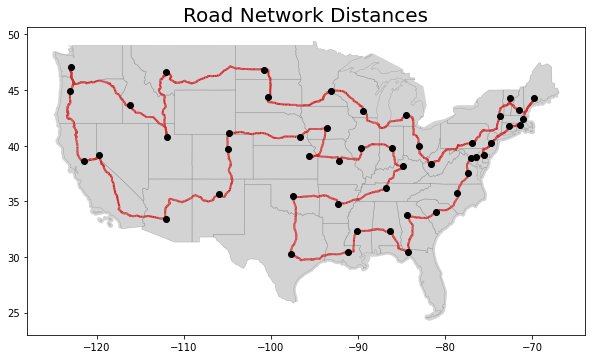

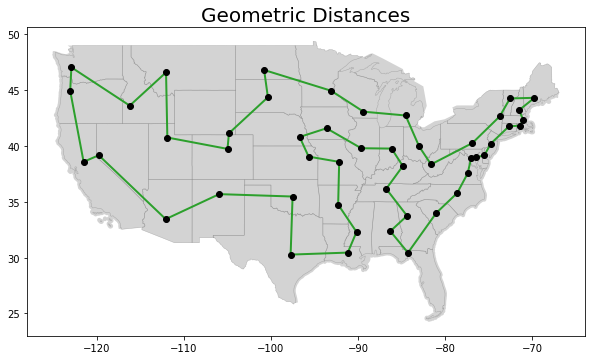

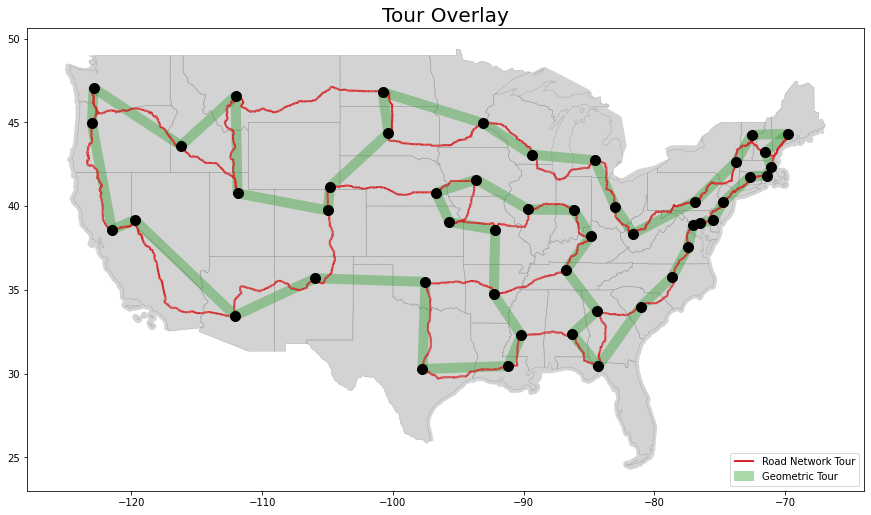

In [31]:
fig,ax = plt.subplots(figsize = (10,10))
cap_coords_gdf.plot(ax = ax, zorder = 5, color = 'black')
us_state_borders.boundary.plot(ax = ax, color = 'gray', lw = 0.5, alpha = 0.5, zorder = 0)
us_poly_gdf.plot(ax = ax, zorder = -1, color = 'lightgray')
ax = tsp_shortest_paths.plot(ax = ax, color = "tab:red", lw = 2, alpha = 1, zorder = 2)
ax.set_title('Road Network Distances', fontdict = {'fontsize': 20});

fig,ax = plt.subplots(figsize = (10,10))
cap_coords_gdf.plot(ax = ax, zorder = 5, color = 'black')
us_state_borders.boundary.plot(ax = ax, color = 'gray', lw = 0.5, alpha = 0.5, zorder = 0)
us_poly_gdf.plot(ax = ax, zorder = -1, color = 'lightgray')
ax = cap_to_cap_tour_gdf.plot(ax = ax, color = "tab:green", lw = 2, alpha = 1, zorder = 1)
ax.set_title('Geometric Distances', fontdict = {'fontsize': 20});

fig,ax = plt.subplots(figsize = (15,15))
cap_coords_gdf.plot(ax = ax, zorder = 5, color = 'black', markersize = 100)
us_state_borders.boundary.plot(ax = ax, color = 'gray', lw = 0.5, alpha = 0.5, zorder = 0)
us_poly_gdf.plot(ax = ax, zorder = -1, color = 'lightgray')
ax = tsp_shortest_paths.plot(ax = ax, color = "tab:red", lw = 2, alpha = 1, zorder = 2, label = 'Road Network Tour')
ax = cap_to_cap_tour_gdf.plot(ax = ax, color = "tab:green", lw = 10, alpha = 0.4, zorder = 1, label = 'Geometric Tour')
ax.legend(loc = 'lower right')
ax.set_title('Tour Overlay', fontdict = {'fontsize': 20});



[[1]]() Map data from [Open Street Maps](https://www.openstreetmap.org) is made available here under the [Open Database License (ODbL)](https://www.openstreetmap.org/copyright).

[[2]]() This product uses Census Bureau Data but is not endorsed or certified by the Census Bureau.